# Dựng hệ thống nhận diện ảnh đơn giản dùng Keras và Tensorflow với pretrained weights ResNet

Có 3 cuộc thi phổ biến trong mảng computer vision mà giới học thuật đánh giá đã có ảnh hưởng rất lớn là: [ImageNet ILSVRC](http://www.image-net.org/challenges/LSVRC/), [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), và [COCO](http://mscoco.org/dataset/#detections-challenge2016).

Trước mắt, hãy xem [danh sách đối tượng ảnh nhận dạng được của ILSVRC](https://gist.github.com/gregchu/134677e041cd78639fea84e3e619415b). Về cơ bản, hệ thống của ta sẽ có thể nhận dạng được khoảng 1000 đối tượng thường gặp hàng ngày nằm trong danh sách các categories dưới đây:

In [ ]:
dog
bear
chair
car
keyboard
crate
crib
flagpole
iPod
boat
minivan
necklace
parachute
pillow
table
purse
racket
rifle
school bus
saxophone
soccer ball
sock
stage
stove
torch
vacuum
vending machine
window
traffic light
menu
plate
broccoli
red wine

## Keras and TensorFlow
[Keras](https://keras.io/) is a high-level neural network library that serves as an easy-to-use abstraction layer on top of the numerical computation library [TensorFlow](http://tensorflow.org/). Thông qua module keras.applications, keras còn cho phép ta dùng các convolutional network models đã thắng giải ILSVRC như là ResNet50 (phát triển bởi Microsoft Research) và InceptionV3 (phát triển bởi Google Research). Vào các đường link trên để cài đặt theo hướng dẫn.

Mục tiêu là viết một chương trình python nhỏ với đối số hoặc là:
1. đường dẫn đến file trên máy tính
2. link đến một hình ảnh

và xuất ra top 3 dự đoán nhóm (trong danh sách nêu trên) mà nội dung ảnh này mô tả (và xác xuất của mỗi nhóm)

In [1]:
# https://medium.com/@moreless/how-to-fix-python-ssl-certificate-verify-failed-97772d9dd14c
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

## ResNet
Để bắt đầu, ta dùng model ResNet50 (technical paper [ở đây](https://arxiv.org/pdf/1512.03385)) và setup nó với các trọng số đã được đào tạo cho cuộc thi ImageNet ILSVRC.

ResNet viết tắt của Residual Networks là một mạng neuron thần kinh cổ điển được sử dụng làm nền tảng cho nhiều công việc trong ngành thị giác máy tính (computer vision). Mô hình này là mô hình chiến thắng trong thử thách ImageNet năm 2015. Bước đột phá cơ bản với ResNet là nó cho phép đào tạo thành công các mạng thần kinh cực kỳ sâu với hơn 150 lớp. Trước khi có ResNet, việc đào tạo các mạng lưới thần kinh sâu là rất khó khăn do vấn đề biến mất độ dốc (vanishing gradients).

AlexNet, hệ thống chiến thắng ImageNet 2012 và là mô hình  đầu tiên tập trung vào học sâu chỉ có 8 lớp chập, mạng VGG có 19 và Inception hoặc GoogleNet có 22 lớp và ResNet 152 có 152 lớp. 
![DepthNetwork](https://miro.medium.com/max/756/1*3ND8w0xwiK3sOYLllGaQVw.png)

Việc tăng độ sâu của network không chỉ đơn giản là chồng thêm các lớp lên nhau. Vấn đề biến mất độ dốc nêu trên xảy ra khi đạo hàm thành phần (partial derivatives ~ hay còn gọi là gradients) được truyền ngược lại lớp trước. Nhiều phép nhân liên tục lặp lại có thể khiến cho số gradient trở nên cực nhỏ. Khi network càng sâu hơn, kết quả không trở nên tốt hơn (đi ngang) hay thậm chí quay đầu thành kém đi.

ResNet giới thiệu khái niệm nhảy cóc (skip connection), và đây có thể là lý do khiến nó thành công:
   1. Skip connection giúp giải quyết 1 phần vấn đề vanishing gradient bằng các tạo ra các đường tắt để gradient chạy ngược qua.
   2. Nó cho phép model học một hàm identity và đảm bảo rằng lớp sâu hơn sẽ thực hiện ít nhất là tốt ngang với lớp trước đó, và không tệ hơn.

Ở đây chúng ta sử dụng ResNet-50 là phiên bản nhỏ hơn của ResNet 152 và thường được sử dụng làm điểm bắt đầu cho việc chuyển nội dung học (transfer learning). Model này được học từ 1.2tr bức ảnh trong khoảng thời gian 2-3 tuần trên nhiều GPUs


In [2]:
!pip install Pillow

     |████████████████████████████████| 2.1MB 790kB/s eta 0:00:01    |█▌                              | 102kB 790kB/s eta 0:00:03


In [3]:
from PIL import Image # cài Pillow, không cài cải 2 PIL & Pillow
from io import BytesIO
import sys
import requests
import matplotlib.pyplot as plt

In [9]:
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')
target_size = (224, 224)

Using TensorFlow backend.


### Hàm dự đoán
Ngay lập tức, ta đã có thể viết hàm `predict` để nhận dạng ảnh

In [5]:
def predict(model, img, target_size, top_n=3):
    """Run model prediction on image
    Args:
    model: keras model
    img: PIL format image
    target_size: (width, height) tuple
    top_n: # of top predictions to return
    Returns:
    list of predicted labels and their probabilities
    """
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return decode_predictions(preds, top=top_n)[0]

Ta sẽ cần khá nhiều giải thích về hàm trên. Để dùng kiến trúc ResNet50, `target_size` phải bằng đúng `(224,224)`. Nhiều cấu trúc CNN có đầu vào cố định để đơn giản hóa quá trình tiền xử lý và ResNet50 là một cấu trúc như vậy. Các bước cụ thể:

* `image.img_to_array`: chuyển một ảnh dạng [PIL - Python Imaging Library](https://pillow.readthedocs.io/en/4.0.x/) thành một mảng numpy
* `np.expand_dims`: chuyển ảnh có kích thước `(224,224,3)` thành tuple `(1,224,224,3)`. Lý do là hàm `model.predict` yêu cầu mảng 4 chiều là đầu vào, với tham số chiều thứ 4 tương ứng với kích cỡ batch. Nghĩa là, nếu muốn, chúng ta có thể nhận dạng nhiều ảnh cùng lúc.
* `preprocess_input`: Đây là một bước **cực kỳ quan trọng** mà nếu bỏ qua sẽ làm cho toàn bộ xác xuất dự đoán bị sai lệch. Bước điều chỉnh trung bình (mean centering) này còn được gọi là chuẩn hóa dữ liệu **[data normalization](https://en.wikipedia.org/wiki/Feature_scaling)**, một khái niệm căn bản của machine learning.
* `model.predict`: thực hiện phân tích ảnh và đưa ra dự đoán.
* `decode_predictions`: lấy nhãn được mã hóa từ bước trên và trả ra nhãn mà con người đọc được từ tập hợp ImageNet ILSVRC.

Module `keras.applications` cung cấp sẵn 4 kiến trúc: ResNet50, InceptionV3, VGG16, VGG19, XCeption. Ở đây chúng ta chọn ResNet50, nhưng bạn có thể đổi kiến trúc khác để thử. Xem thêm ở mục [Application của Keras](https://keras.io/applications/)

### Vẽ đồ thị
Ta có thể dùng `matplotlib` để in kết quả ra đồ thị nằm ngang như sau:

In [4]:
def plot_preds(image, preds):  
    """Displays image and the top-n predicted probabilities 
     in a bar graph  
    Args:    
    image: PIL image
    preds: list of predicted labels and their probabilities  
    """  
    #image
    plt.imshow(image)
    plt.axis('off')

    #bar graph
    plt.figure()  
    order = list(reversed(range(len(preds))))  
    bar_preds = [pr[2] for pr in preds]
    labels = (pr[1] for pr in preds)
    plt.barh(order, bar_preds, color="blue", alpha=0.5)
    plt.yticks(order, labels)
    for i, v in enumerate(reversed(bar_preds)):
        plt.text(v, i, "{0:.2f}%".format(v * 100), color='blue', fontweight='bold')
    
    plt.xlabel('Probability')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()

Gói ghém tất cả các thành phần vào nhau:

In [7]:
def classify(image=None, image_url=None):
    if image is not None:
        img = Image.open(image)
        preds = predict(model, img, target_size)
        plot_preds(img, preds)
    if image_url is not None:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        preds = predict(model, img, target_size)
        plot_preds(img, preds)

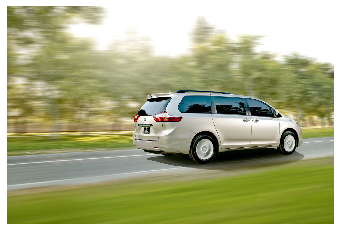

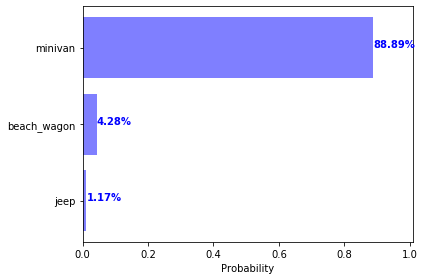

In [44]:
classify(image_url="http://i.imgur.com/cg37Ojo.jpg")

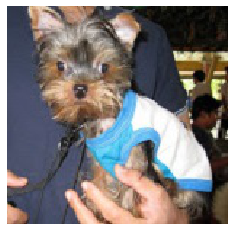

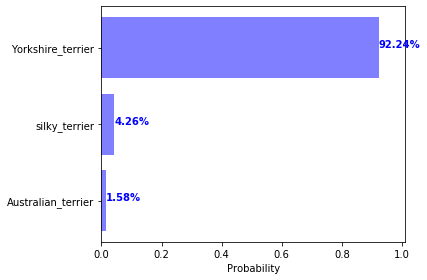

In [43]:
classify(image="IMG_9333.JPG")

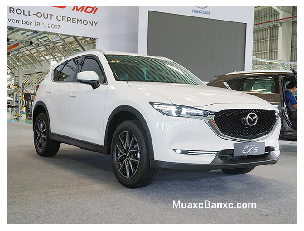

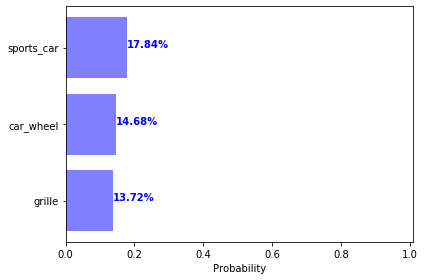

In [10]:
classify(image_url="https://muaxegiatot.vn/wp-content/uploads/2019/05/gia-xe-mazda-cx5-25l-awd-2019-muaxegiatot-vn-30.jpg")